In [1]:
# import standard libraries
import regex as re
from glob import glob
import numpy as np
# third-party libraries
import dask
import dask.dataframe as dd
import dask.multiprocessing
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, MeanShift, SpectralClustering
from sklearn.preprocessing import StandardScaler
# local libraries
from fbd import read_parquet, plot_dendrogram

In [2]:
# choose cluster method
cluster_method = ['kmeans', 'agglomerative_ward',
                  'meanshift', 'spectral'][3]

In [3]:
# choose factor model
num_feat = 5

# Data

In [4]:
filenames = glob(f'data/loadings/{num_feat}_factor/*.parquet')

In [5]:
len(filenames)

2497

In [6]:
dates = [re.findall(r'\d{4}-\d{2}-\d{2}', f)[0] for f in filenames]
dates_dt = pd.to_datetime(dates).sort_values()
dates_str = dates_dt.strftime('%Y-%m-%d')

In [7]:
# get filenames again in correct order
filenames = [glob(f'data/loadings/{num_feat}_factor/{d}.parquet')[0] for d in dates_str]

In [8]:
const_mat = pd.read_csv('data/russell3000.csv.gz', compression='gzip',
                        index_col=0)

In [9]:
permnos = const_mat.columns.values

## Clean company information

In [10]:
info = pd.read_csv('data/permno_info.csv.gz', compression='gzip',
                   index_col=0)

info['permno'] = info['permno'].astype(int).astype(str)
# get rid of nan in naics
info.dropna(how='any', subset=['naics'], inplace=True)
# remove duplicate rows from info
info.drop_duplicates(subset=['permno'], inplace=True, keep='last', ignore_index=True)

# get sector from naics
info['naics'] = info['naics'].astype(int).astype(str)
info['sector'] = info['naics'].str[:2]
info[['naics', 'sector']] = info[['naics', 'sector']].astype(int)

# we won't be needing siccd actually
info.drop(columns=['siccd'], inplace=True)

# set permno to index
info.set_index('permno', inplace=True)

In [11]:
info.isna().sum()

comnam     0
naics      0
ticker    12
sector     0
dtype: int64

In [12]:
# missing info securities
missing_permnos = list(set(permnos) - set(info.index.values))
missing_permnos

['14065',
 '14643',
 '18807',
 '15120',
 '91638',
 '15829',
 '17782',
 '18579',
 '14712',
 '16877',
 '14247',
 '92615',
 '18363',
 '13250',
 '14271',
 '14789',
 '15044',
 '19148',
 '92494',
 '19084',
 '18151',
 '14669']

# Clustering

In [13]:
num_sectors = len(info['sector'].unique())
num_sectors

24

In [14]:
def compute_clusters(i):
    f = filenames[i]
    t = dates_str[i]
    loadings = read_parquet(f)
    loadings.dropna(how='all', axis=1, inplace=True)
    # get permnos as observations to cluster
    loadings_t = loadings.T
    # perform agglomerative clustering using ward linkage
    if cluster_method == 'kmeans':
        ac = KMeans(n_clusters=num_sectors, random_state=0)
    elif cluster_method == 'agglomerative_ward':
        ac = AgglomerativeClustering(n_clusters=num_sectors, linkage='ward')
    #elif cluster_method == 'agglomerative_average':
    #    ac = AgglomerativeClustering(n_clusters=num_sectors, linkage='average')
    #elif cluster_method == 'agglomerative_complete':
    #    ac = AgglomerativeClustering(n_clusters=num_sectors, linkage='average')
    elif cluster_method == 'meanshift':
        ac = MeanShift()
    elif cluster_method == 'spectral':
        ac = SpectralClustering(n_clusters=num_sectors, random_state=0)
    #loadings_t_trans = StandardScaler().fit_transform(loadings_t)
    ac = ac.fit(loadings_t)
    #ac = ac.fit(loadings_t_trans)
    labels = pd.DataFrame(columns=[t], index=loadings_t.index, data=ac.labels_)
    # filter loadings according to index in info (get rid of permnos that are in loadings and not in info)
    labels = labels[labels.index.isin(info.index)]
    return labels

In [15]:
# default setting for Dask
dask.config.set(scheduler='processes')

In [16]:
%%time
with ProgressBar():
    promises = [dask.delayed(compute_clusters)(i) for i, _ in enumerate(filenames)]
    all_labels = dask.compute(promises)[0]

[########################################] | 100% Completed |  2hr 56min 34.0s
CPU times: user 4min 2s, sys: 41.6 s, total: 4min 44s
Wall time: 2h 56min 34s


In [17]:
info_labels = pd.concat([info] + all_labels, axis=1, ignore_index=False)

In [18]:
# save to parquet
info_labels.columns = info_labels.columns.astype(str)
info_labels.index = info_labels.index.astype(str)
info_labels.to_parquet(f'data/clustering/{num_feat}_factor/{cluster_method}.parquet')

In [19]:
info_labels

,comnam,naics,ticker,sector,2010-02-01,2010-02-02,2010-02-03,2010-02-04,2010-02-05,2010-02-08,...,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-23,2019-12-24,2019-12-26,2019-12-27,2019-12-30,2019-12-31
10026,J & J SNACK FOODS CORP,311813,JJSF,31,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10032,PLEXUS CORP,334418,PLXS,33,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10051,HANGER INC,339113,HNGR,33,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10065,ADAMS EXPRESS CO,525910,ADX,52,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10104,ORACLE CORP,511210,ORCL,51,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93428,BROADSOFT INC,511210,BSFT,51,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93429,C B O E GLOBAL MARKETS INC,523210,CBOE,52,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93431,PACTERA TECHNOLOGY INTL LTD,541512,PACT,54,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93433,VOLTARI CORP,511210,VLTC,51,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dendrogram 

In [20]:
# load some loadings
f = filenames[0]
t = dates_str[0]
loadings = read_parquet(f)
loadings.dropna(how='all', axis=1, inplace=True)
loadings_t = loadings.T

In [21]:
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
ac = ac.fit(loadings_t)

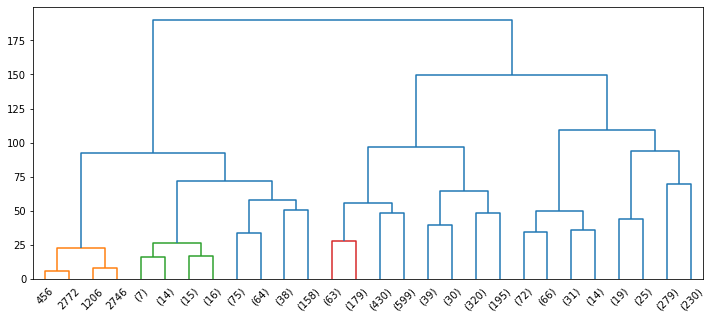

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_dendrogram(ac, truncate_mode='level', p=4, ax=ax, color_threshold=33)